In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import treeswift
import math

In [253]:
%load_ext autoreload
%autoreload 2
    
import helpers.utils
from helpers.utils import build_summary_df
from helpers.utils import plot_genotype_confidence
from helpers.utils import clustermap_genos
from helpers.utils import distdict_to_df, leaf_pairs, get_geno_dict
from helpers.utils import im_ehd, empirical_site_dists, ehd, sm_ehd, pair_metrics
from helpers.utils import plot_concordance_scatterplot, plot_concordance_distribution
from helpers.utils import plot_state_counts, report_genotype_call_stats, save_df_to_pdf
from helpers.utils import plot_correlation, plot_bl_variance, add_internal_labels, branch_table
from helpers.utils import plot_tree_3d, edge_ratio_table, plot_genotypecall_summary

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
import sys
sys.path.insert(0, "/Users/gc3045/git/fast-laml/scripts") 
import euclidean_solver as es

In [66]:
# pip install legacy-cgi

In [114]:
inputs_basename = "/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/inputs/"
plotdir = "/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/plots/"
lamlpro_col2_basename = "/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/runjobs/outputs_baseMemoir_colony2/fastlaml_baseMemoir.colony2.published"
lamlpro_col5_basename = "/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/runjobs/outputs_baseMemoir_colony2/fastlaml_baseMemoir.colony5.stepwise_addition_03"

In [6]:
bm_input_geno = inputs_basename + "baseMemoir_colony2_baseMemoir_genotypes.csv"
lp_map_geno = lamlpro_col2_basename + "_posterior_argmax.csv"

bm_treefile = inputs_basename + "trees/baseMemoir.colony2.published.nwk"
lp_treefile = lamlpro_col2_basename + "_tree.newick"

centroids_fname = inputs_basename + "colony2_centroids.txt"
# bm_c5_input_geno = inputs_basename + "baseMemoir_colony5_baseMemoir_genotypes.csv
# lp_c5_map_geno = lamlpro_col5_basename + "_posterior_argmax.csv"

In [7]:
bm_input_geno_df = pd.read_csv(bm_input_geno)
lp_map_geno_df = pd.read_csv(lp_map_geno, skiprows=2, index_col=0)
centroids_df = pd.read_csv(centroids_fname, sep="\t", header=None, index_col=0)

In [8]:
bm_tree = treeswift.read_tree_newick(bm_treefile)
lp_tree = treeswift.read_tree_newick(lp_treefile)

#### Genotype plausibility

In [120]:
summary_df = build_summary_df(bm_input_geno_df, lp_map_geno_df)

[build_summary_df] merged rows: 8322 | LP matches: 8322 | both_present: 8322 | agree: 6773 (0.8138668589281423) | disagree_true: 1549 (0.18613314107185772)


'/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/plots//colony2_genotype_probabilities.pdf'

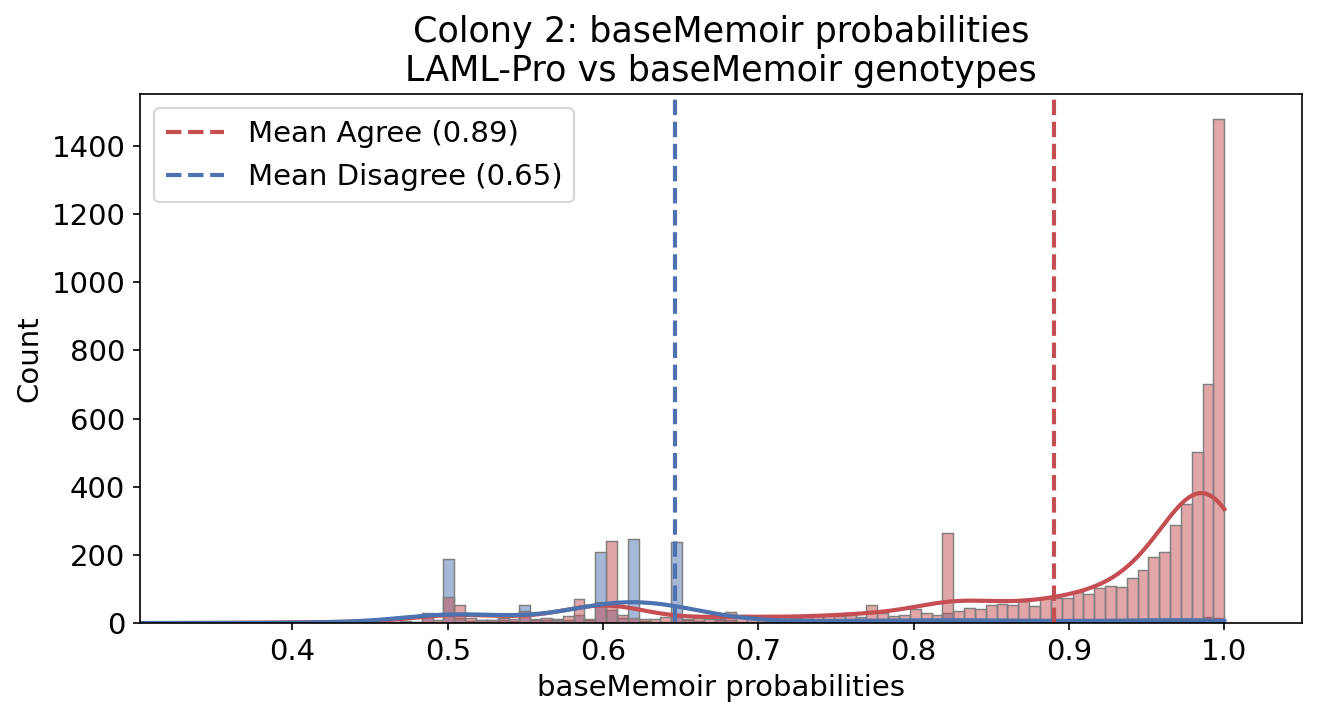

In [122]:
plot_genotype_confidence(summary_df, title="Colony 2: baseMemoir probabilities\nLAML-Pro vs baseMemoir genotypes",
                         outfile=f"{plotdir}/colony2_genotype_probabilities.pdf",
                         bins=100)

In [124]:
bm_geno_df = bm_input_geno_df[['cell_name', 'target_site', 'bM_geno']]
bm_geno_df = bm_geno_df.pivot(
    index="cell_name", 
    columns="target_site", 
    values="bM_geno"
).sort_index(axis=1).fillna(-1)

In [125]:
lp_map_geno_df.columns = bm_geno_df.columns
lp_map_geno_df = lp_map_geno_df.loc[[x for x in lp_map_geno_df.index if not x.startswith('internal')], :]
lp_map_geno_df.index = [int(x) for x in lp_map_geno_df.index]
bm_geno_df.index = [int(x) for x in bm_geno_df.index]

In [126]:
(lp_map_geno_df == -1).sum().sum()

np.int64(240)

/Users/gc3045/miniconda3/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/Users/gc3045/miniconda3/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



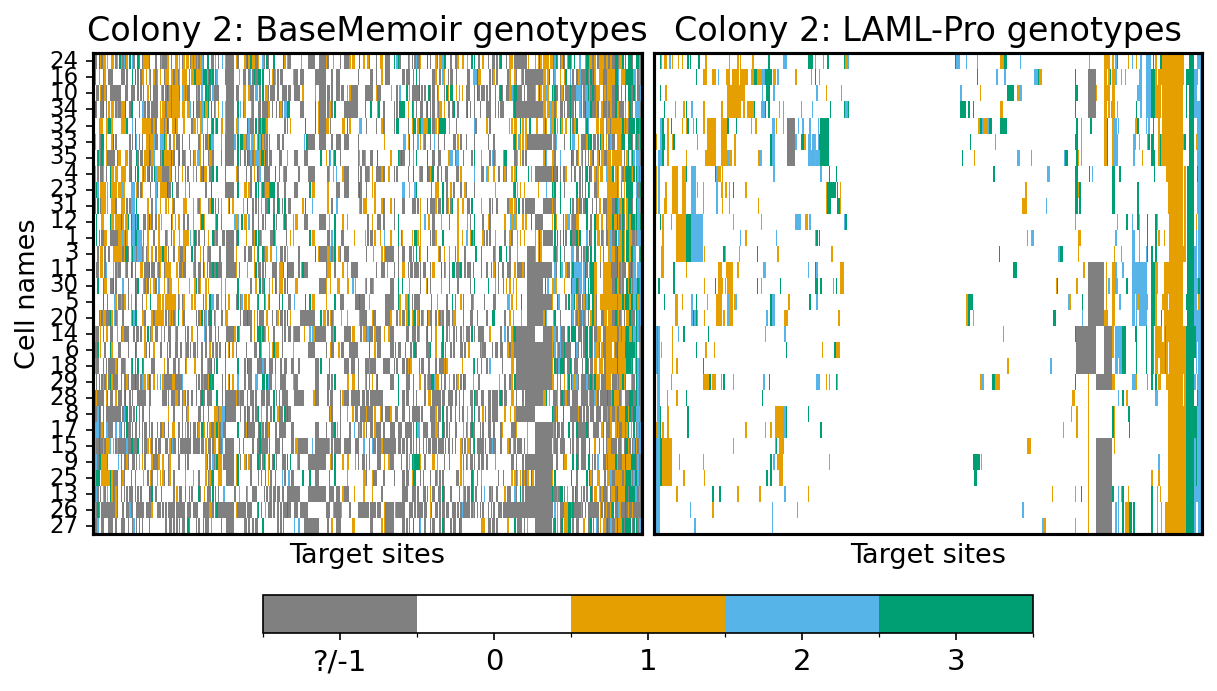

In [128]:
clustermap_genos(bm_geno_df, lp_map_geno_df, metric='hamming', method='complete', title="Colony 2")

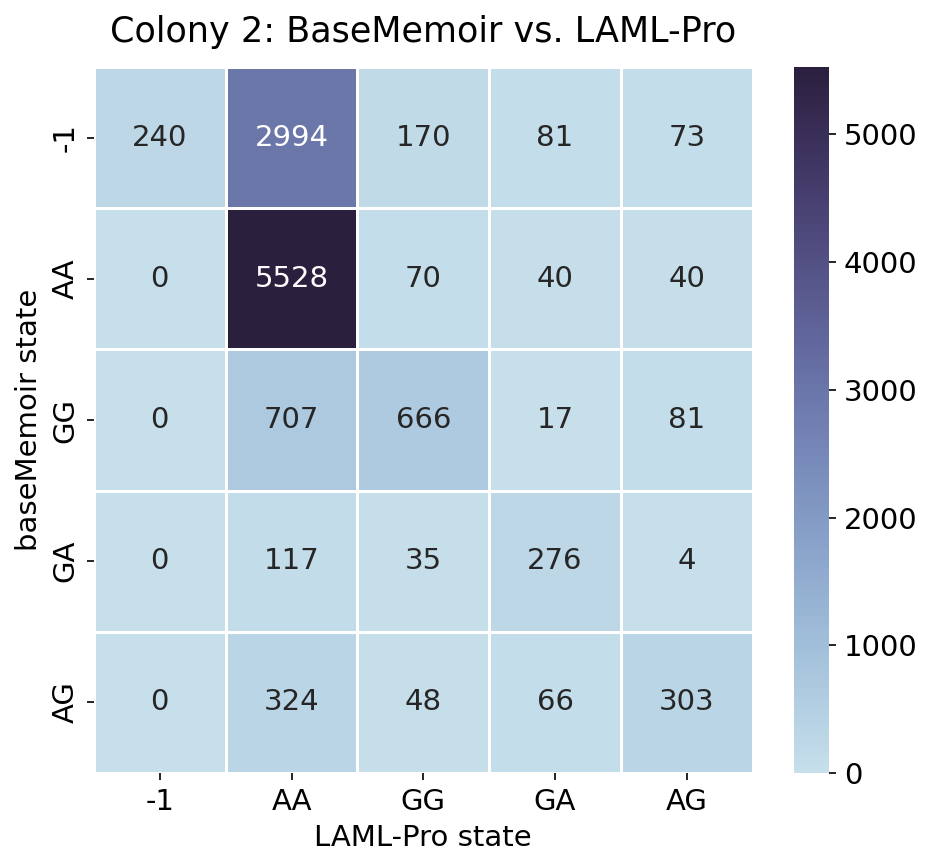

In [258]:
counts = plot_state_counts(bm_geno_df, lp_map_geno_df, title="Colony 2: BaseMemoir vs. LAML-Pro",
                          outfile=f"{plotdir}/colony2_genotype_counts.pdf")

In [133]:
counts

,-1,AA,GG,GA,AG
-1,240,2994,170,81,73
AA,0,5528,70,40,40
GG,0,707,666,17,81
GA,0,117,35,276,4
AG,0,324,48,66,303


In [259]:
counts_trim = (
    counts[counts.index != '-1']
    .drop(columns='-1'))
counts_trim

,AA,GG,GA,AG
AA,5528,70,40,40
GG,707,666,17,81
GA,117,35,276,4
AG,324,48,66,303


In [260]:
unedited = ['AA']            # baseMemoir (rows): AA = unedited
edited   = ['GG','GA','AG']  # GG/GA/AG = edited

uu = counts_trim.loc[unedited, unedited].to_numpy().sum()  # unedited → unedited
ue = counts_trim.loc[unedited, edited].to_numpy().sum()    # unedited → edited
eu = counts_trim.loc[edited, unedited].to_numpy().sum()    # edited → unedited
ee = counts_trim.loc[edited, edited].to_numpy().sum()      # edited → edited

summary_2x2 = pd.DataFrame(
    [[uu, ue],
     [eu, ee]],
    index=pd.Index(['Unedited','Edited'], name=''),
    columns=pd.Index(['Unedited','Edited'])
)

summary_2x2

,Unedited,Edited
,,
Unedited,5528,150
Edited,1148,1496


In [208]:
shared_sites = [c for c in bm_geno_df.columns if c in lp_map_geno_df.columns]

# Flatten both matrices into tidy long format
bm_long = bm_geno_df[shared_sites].stack().reset_index()
bm_long.columns = ["cell_name", "target_site", "bm_state"]

lp_long = lp_map_geno_df[shared_sites].stack().reset_index()
lp_long.columns = ["cell_name", "target_site", "lp_state"]

merged = (
    bm_input_geno_df.merge(bm_long, on=["cell_name", "target_site"])
                    .merge(lp_long, on=["cell_name", "target_site"])
)

Consider showing the normalized densities

✅ Saved figure to: /Users/gc3045/git/laml2-experiments/real_data/baseMemoir/plots//colony2_genotypecall_summary.pdf


<string>:48: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



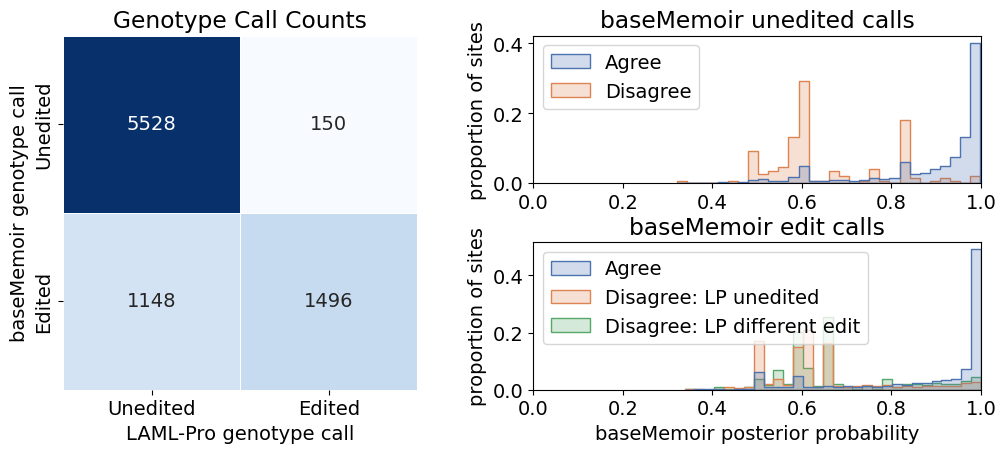

In [264]:
fig, (ax_heat, ax_uned, ax_ed) = plot_genotypecall_summary(
    summary_2x2, merged, outfile=f"{plotdir}/colony{colony}_genotypecall_summary.pdf"
)

##### stats_df = report_genotype_call_stats(counts)
save_df_to_pdf(stats_df, filename=f"{plotdir}/colony2_genotype_call_stats.pdf", title=None, floatfmt="{:.4f}", fontsize=10)

#### Genotype concordance with tree topology

In [350]:
bm_distmat = distdict_to_df(bm_tree.distance_matrix(leaf_labels=True))
lp_distmat = distdict_to_df(lp_tree.distance_matrix(leaf_labels=True))

In [351]:
bm_leaf_pairs = leaf_pairs(bm_distmat)
lp_leaf_pairs = leaf_pairs(lp_distmat)

In [352]:
bm_genodict = get_geno_dict(bm_input_geno_df)
hat = empirical_site_dists(bm_genodict)

In [353]:
bm_concordance = pair_metrics(bm_leaf_pairs, bm_genodict, hat)
lp_concordance = pair_metrics(lp_leaf_pairs, bm_genodict, hat)

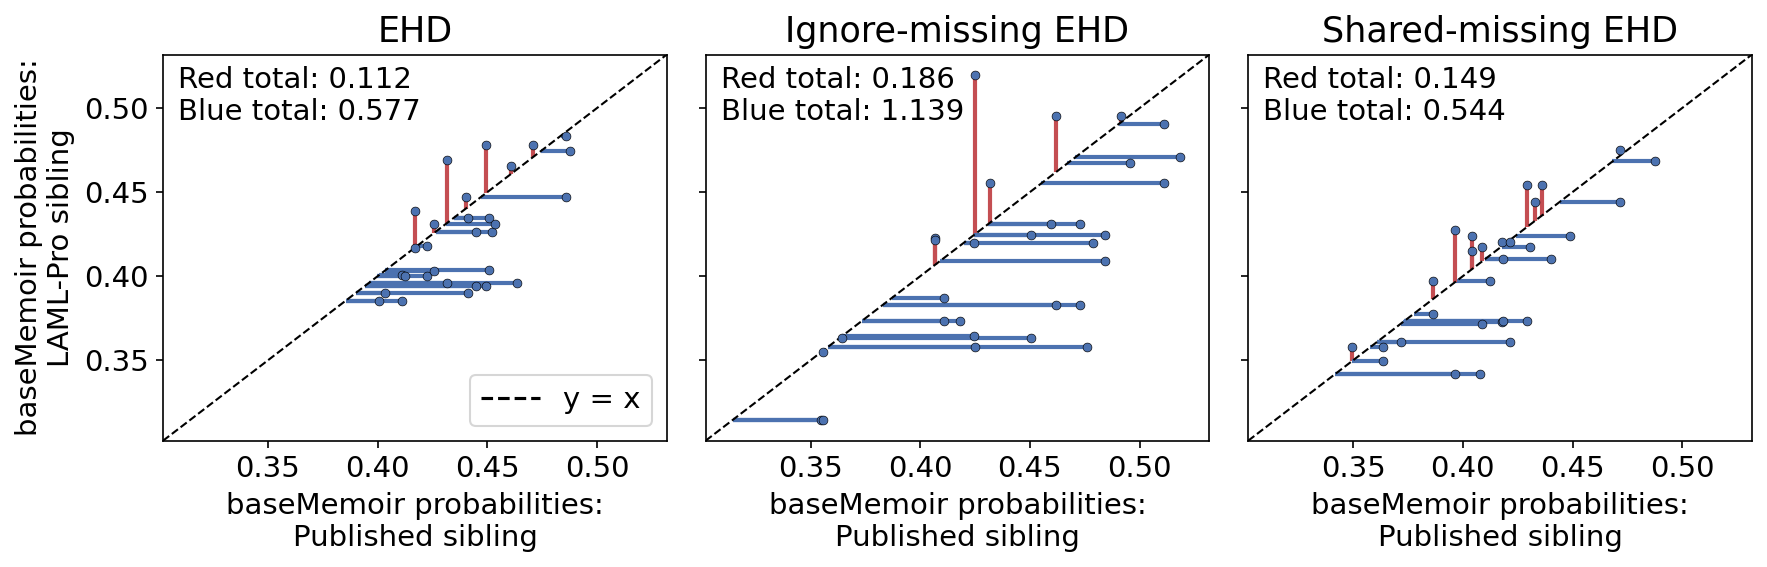

In [371]:
plot_concordance_scatterplot(bm_concordance, lp_concordance, 
                          outfile=f"{plotdir}/colony2_genotype_scatterplot.pdf")

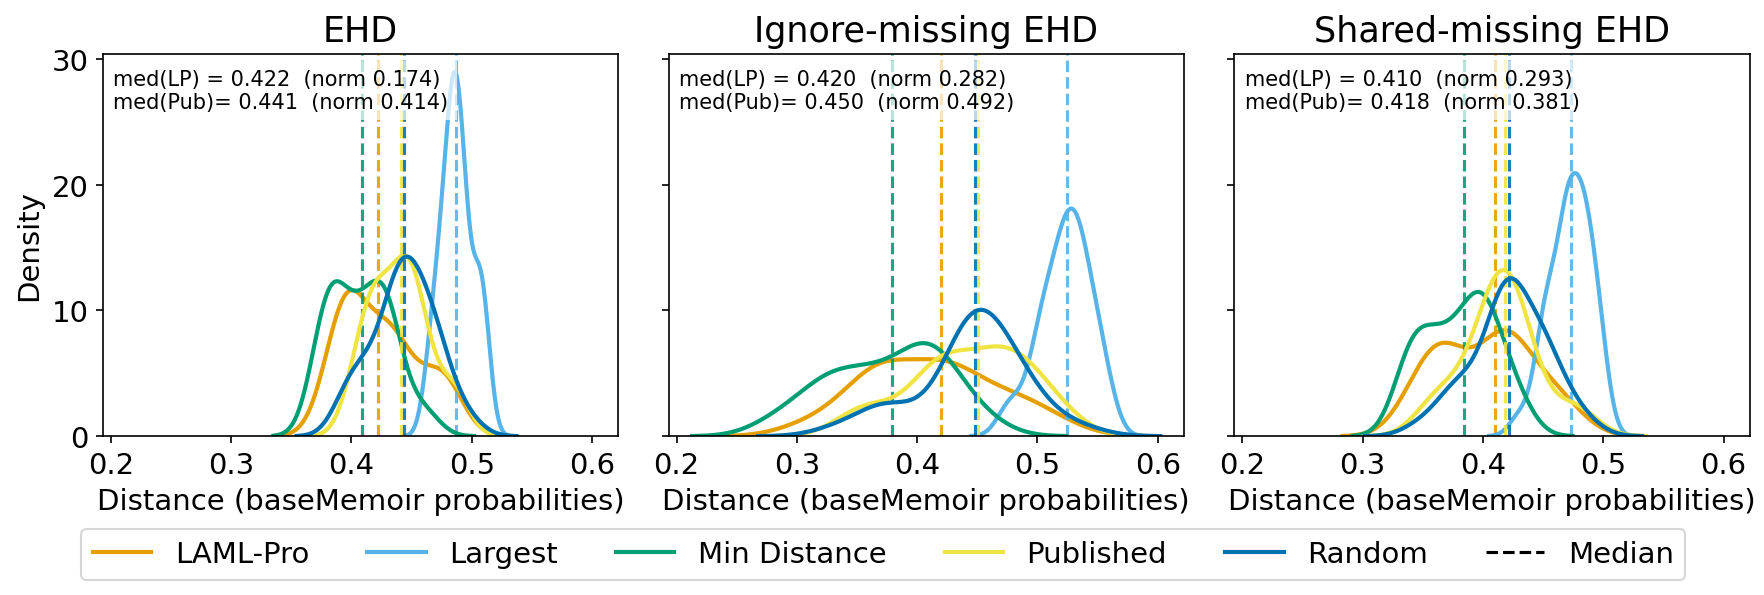

In [372]:
plot_concordance_distribution(bm_concordance, lp_concordance, bm_genodict, hat,
                          outfile=f"{plotdir}/colony2_genotype_distribution.pdf")

#### Spatial analysis

In [498]:
# scale trees

lp_tree.collapse_short_branches(0.0005)
lp_tree.root.set_edge_length(0.0)

tau = 72 # hours
bm_tree.scale_edges(tau/bm_tree.height())
lp_tree.scale_edges(tau/lp_tree.height())

var_x, var_y = centroids_df.var(axis=0)
print("Variance", var_x, var_y)
diffusion_scale = (var_x + var_y)/(2*tau)

bm_tree.scale_edges(diffusion_scale)
lp_tree.scale_edges(diffusion_scale)

add_internal_labels(bm_tree)
add_internal_labels(lp_tree)

print("Tree heights", bm_tree.height(), lp_tree.height())

Variance 106271.56624600854 185842.79625344044
Tree heights 146057.1812497245 146057.18124972453


In [499]:
bm_tree.write_tree_newick(bm_treefile[:-4] + ".scaled.newick")
lp_tree.write_tree_newick(lp_treefile[:-7] + ".scaled.newick")

#### Spatial visualization

In [7]:
lp_tree = treeswift.read_tree_newick(lp_treefile[:-7] + ".scaled.newick")
bm_tree = treeswift.read_tree_newick(bm_treefile[:-4] + ".scaled.newick")

In [8]:
bm_distmat = distdict_to_df(bm_tree.distance_matrix(leaf_labels=True))
lp_distmat = distdict_to_df(lp_tree.distance_matrix(leaf_labels=True))

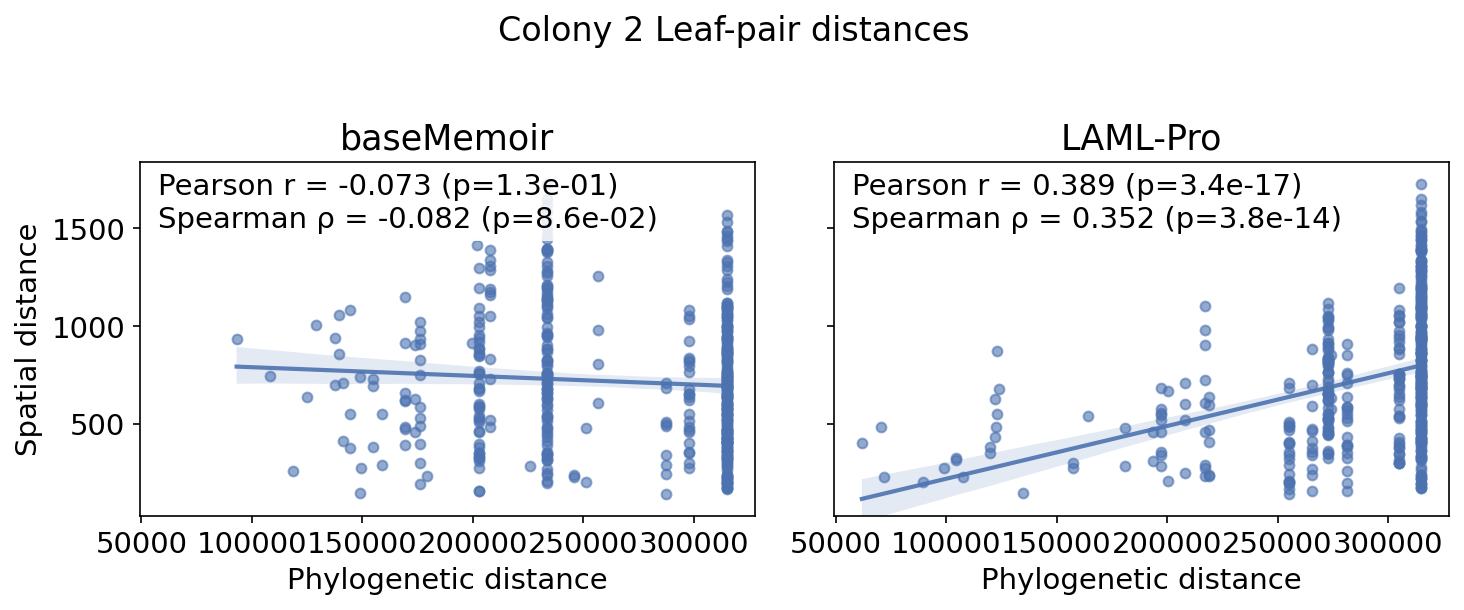

In [9]:
# plot phylogenetic distance against spatial distance and compute pearson correlation 
fig, axes = plot_correlation(centroids_df, bm_distmat, lp_distmat, title="Colony 2 Leaf-pair distances",
                outfile=f"{plotdir}/colony2_spatial_correlation.pdf")

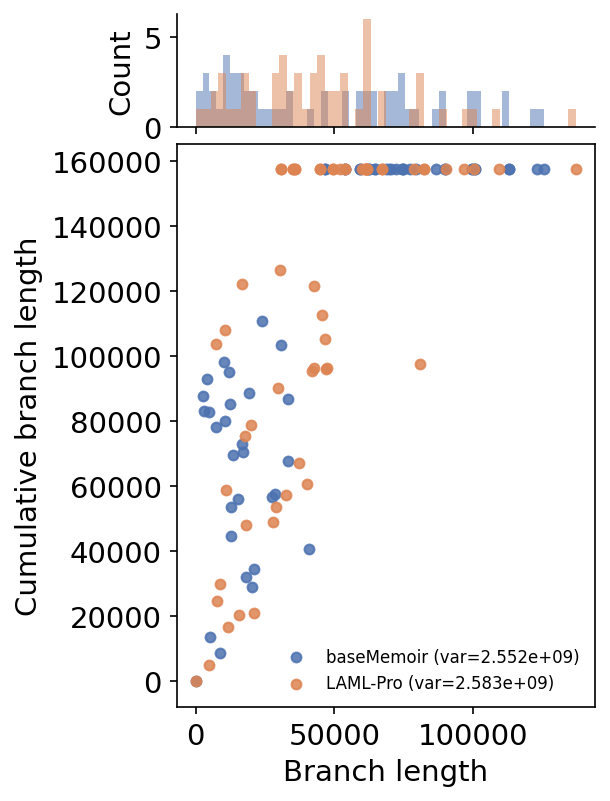

In [29]:
# generate the branch length vs. z (cumulative branch length) # annotate with histogram
bm_tree_df = branch_table(bm_tree)
lp_tree_df = branch_table(lp_tree)

fig = plot_bl_variance(bm_tree_df, lp_tree_df, title=None, 
                 outfile=f"{plotdir}/colony2_branchlen_variance.pdf")

#### 3D interactive plot

In [112]:
# generate the 3D interactive plot

lp_tree = treeswift.read_tree_newick(lp_treefile)
bm_tree = treeswift.read_tree_newick(bm_treefile)

lp_tree.collapse_short_branches(0.0005)
lp_tree.root.set_edge_length(0.0)

tau = 72 # hours
bm_tree.scale_edges(tau/bm_tree.height())
lp_tree.scale_edges(tau/lp_tree.height())

analysis_basename = "/Users/gc3045/git/laml2-experiments/real_data/analysis/"
colony = 2

centroids_df.columns = ["X", "Y"]
ancestral_labeling_df = pd.read_csv(f"{analysis_basename}/colony{colony}_bm_ancestral_labeling.txt", index_col=0)
ancestral_labeling_df.columns = centroids_df.columns
bm_merged_df = pd.concat([ancestral_labeling_df, centroids_df], axis=0)

centroids_df.columns = ["X", "Y"]
ancestral_labeling_df = pd.read_csv(f"{analysis_basename}/colony{colony}_lp_ancestral_labeling.txt", index_col=0)
ancestral_labeling_df.columns = centroids_df.columns
lp_merged_df = pd.concat([ancestral_labeling_df, centroids_df], axis=0)

In [117]:
fig = plot_tree_3d(lp_tree, lp_merged_df, x_col="X", y_col="Y",
                   title="LAML-Pro: Cells in 3D",
                   outfile=f"{plotdir}/colony{colony}_lamlpro_tree.html")

Saved interactive HTML to: /Users/gc3045/git/laml2-experiments/real_data/baseMemoir/plots//colony2_lamlpro_tree.html


In [118]:
fig = plot_tree_3d(bm_tree, bm_merged_df, x_col="X", y_col="Y",
                   title="baseMemoir: Cells in 3D",
                   outfile=f"{plotdir}/colony{colony}_baseMemoir_tree.html")

Saved interactive HTML to: /Users/gc3045/git/laml2-experiments/real_data/baseMemoir/plots//colony2_baseMemoir_tree.html


#### Try visualizing the published inferred spatial annotations

Tried visualizing the published baseMemoir inferred spatial annotations, but we don't have a direct comparison since the baseMemoir annotations seem to be in different units (not pixels). 

In [103]:
# # extract baseMemoir published spatial annotations
# import re

# colony = 2
# fname = f"/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/inputs/trees/baseMemoir.pos{colony}.full.newick"
# df_xy_all = extract_locations_df_from_file(fname, include_unlabeled_internals=True)
# df_xy_all = df_xy_all.set_index('cell')

In [104]:
# df_xy_all

In [105]:
# bm_merged_df

In [106]:
# df_xy = df_xy_all
# df = df_xy.copy()
# columns=("x","y")
# leaves=None

# # ensure 'cell' is the index
# if 'cell' in df.columns:
#     df = df.drop_duplicates('cell').set_index('cell')
# df.index = df.index.map(str)

# # keep only requested columns, drop rows with NaNs
# cols = list(columns)
# df = df[cols].dropna(how="any")

# # filter to leaves: either by explicit list or by removing "internal_*"
# if leaves is not None:
#     keep = {str(x) for x in leaves}
#     df = df.loc[df.index.isin(keep)]
# else:
#     df = df[~df.index.str.startswith("internal_")]

#     # convert to dict -> np.array
# bm_xy_dict = {k: df.loc[k, cols].to_numpy(dtype=float) for k in df.index}

In [107]:
# from ete3 import Tree

# fname = "/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/inputs/trees/baseMemoir.colony2.published.nwk"
# tree = Tree(fname, format=1)

In [108]:
# def tree_height(t):
#     """Return max root→leaf distance (tree 'height') using branch lengths."""
#     _leaf, dist = t.get_farthest_leaf()
#     return float(dist)

# def scale_tree_to_height(t, target_height=72.0, in_place=True):
#     """
#     Scale all edges so the tree's height equals target_height.
#     Returns (old_height, scale_factor, new_height).
#     """
#     # If you prefer not to mutate the original tree, copy it:
#     tree = t if in_place else t.copy()

#     old_h = tree_height(tree)
#     if old_h <= 0:
#         raise ValueError("Cannot scale a zero-height tree (max root→leaf distance is 0).")

#     s = target_height / old_h

#     # Multiply every branch length (dist) by s
#     for n in tree.traverse("preorder"):
#         # n.dist is length to parent; root.dist is typically 0
#         if getattr(n, "dist", None) is None:
#             n.dist = 0.0
#         else:
#             n.dist *= s

#     new_h = tree_height(tree)
#     return (old_h, s, new_h, tree)

In [109]:
# print("Current height:", tree_height(tree))

# old_h, scale, new_h, _ = scale_tree_to_height(tree, target_height=72.0, in_place=True)
# print(f"Scaled by {scale:.6g}: {old_h:.6g} → {new_h:.6g}")

# # Quick sanity check:
# assert abs(tree_height(tree) - 72.0) < 1e-6

In [110]:
# model = es.Square_Parsimony(tree, bm_xy_dict)

In [111]:
# fig = plot_tree_3d(bm_tree, df_xy_all, x_col="x", y_col="y",
#                    title="baseMemoir (published): Cells in 3D")

#### Other metrics

In [528]:
N, K = lp_map_geno_df.loc[[n for n in lp_map_geno_df.index if not n.startswith('internal')],].shape

In [529]:
np.sum(bm_input_geno_df['bM_pmax'] > 0.70) / (N * 396)

np.float64(0.5156565656565657)

In [42]:
ratios_df = edge_ratio_table(lp_tree, lp_merged_df, x_col="X", y_col="Y")
print(ratios_df[["node_label","parent_label","edge_length","xy_distance_to_parent","bl_over_xy"]].head())
print(ratios_df[["edge_length","xy_distance_to_parent","bl_over_xy"]].mean(axis=0))

  node_label parent_label  edge_length  xy_distance_to_parent  bl_over_xy
0         23  internal_52    14.146489             199.247997    0.070999
1          8  internal_56    20.478394             100.494118    0.203777
2          3  internal_34    24.585762             113.645649    0.216337
3          1  internal_34    24.585762             113.645649    0.216337
4         31  internal_52    14.146489             199.247997    0.070999
edge_length               21.170365
xy_distance_to_parent    202.391990
bl_over_xy                 0.123217
dtype: float64


In [43]:
ratios_df = edge_ratio_table(bm_tree, bm_merged_df, x_col="X", y_col="Y")
print(ratios_df[["node_label","parent_label","edge_length","xy_distance_to_parent","bl_over_xy"]].head())
print(ratios_df[["edge_length","xy_distance_to_parent","bl_over_xy"]].mean(axis=0))

  node_label parent_label  edge_length  xy_distance_to_parent  bl_over_xy
0         14                 35.328497             394.350458    0.089587
1          5                 27.078871             128.604980    0.210558
2         18                 28.552848             318.881445    0.089541
3         34                 31.434787             438.995194    0.071606
4          9                 29.501543             501.818233    0.058789
edge_length               22.400454
xy_distance_to_parent    263.288483
bl_over_xy                 0.111794
dtype: float64


In [46]:
def _split_kvlist(s: str):
    """Split top-level comma-separated k=v items, ignoring commas inside {...}."""
    parts, buf, depth = [], [], 0
    for ch in s:
        if ch == '{': depth += 1
        elif ch == '}': depth -= 1
        if ch == ',' and depth == 0:
            parts.append(''.join(buf).strip()); buf = []
        else:
            buf.append(ch)
    if buf: parts.append(''.join(buf).strip())
    return parts

def _parse_pair(val: str):
    """Parse '{x,y}' -> (float(x), float(y)) or return None."""
    val = val.strip()
    m = re.match(r'^\{(.*)\}$', val, flags=re.DOTALL)
    if not m:
        return None
    parts = _split_kvlist(m.group(1).strip())
    if len(parts) < 2:
        return None
    try:
        return float(parts[0]), float(parts[1])
    except ValueError:
        return None

def load_newick_from_file(path: str) -> str:
    """Return the first Newick tree found in the file (works for plain .nwk or Nexus)."""
    with open(path, 'r') as f:
        txt = f.read()
    # Try Nexus-style: 'tree XYZ = ( ... );'
    m = re.search(r'=\s*(\(.+?;)', txt, flags=re.DOTALL)
    if m:
        return m.group(1).strip()
    # Fallback: first '( ... );' blob
    m = re.search(r'(\(.+?;)', txt, flags=re.DOTALL)
    if m:
        return m.group(1).strip()
    # Last resort: return raw text
    return txt.strip()

def extract_locations_df_from_file(path: str, include_unlabeled_internals=True) -> pd.DataFrame:
    newick_str = load_newick_from_file(path)
    rows = []
    internal_counter = 0

    # Find all annotation blobs like [&k=v,...] across newlines
    for m in re.finditer(r'\[\&(.*?)\]', newick_str, flags=re.DOTALL):
        kv_blob = m.group(1)

        # Token (node label) immediately before '['; stop at separators '(),:'
        j = m.start() - 1
        while j >= 0 and newick_str[j].isspace():
            j -= 1
        token_end = j
        while j >= 0 and newick_str[j] not in '(),:':
            j -= 1
        token = newick_str[j+1:token_end+1].strip()

        if token:
            node_name = token
        else:
            if not include_unlabeled_internals:
                continue
            internal_counter += 1
            node_name = f"internal_{internal_counter}"

        # Parse k=v pairs
        kv = {}
        for entry in _split_kvlist(kv_blob):
            if '=' in entry:
                k, v = entry.split('=', 1)
                kv[k.strip()] = v.strip()

        # Prefer pair in {x,y}
        xy = None
        if 'locationsp2_locations' in kv:
            xy = _parse_pair(kv['locationsp2_locations'])

        # Fallback to scalar components
        if xy is None:
            v1 = kv.get('locationsp2_locations1')
            v2 = kv.get('locationsp2_locations2')
            if v1 is not None and v2 is not None:
                try:
                    xy = (float(v1), float(v2))
                except ValueError:
                    xy = None

        if xy is not None:
            rows.append({'cell': node_name, 'x': xy[0], 'y': xy[1]})

    return pd.DataFrame(rows, columns=['cell', 'x', 'y'])